# Lab 02: Manual Full-Integer Post-Training Quantization (PTQ) using a LeNet-Inspired CNN

## Overview
In this lab, you will explore how to apply **manual full-integer post-training quantization (PTQ)** to a pre-trained convolutional neural network (CNN).  
You will start with a **pre-trained LeNet-inspired model** trained on the MNIST dataset in full precision (FP32), evaluate its accuracy, and then apply **manual dynamic scaling functions** after each layer to simulate quantization to 8-bit integers.  
Finally, you will compare the accuracy of the quantized model to the original FP32 model and discuss how different integer bit-widths affect performance.

## Learning Objectives
By the end of this lab, you will be able to:
1. Get familiar with **full-integer post-training quantization (PTQ)** and apply it manually to a custom CNN.
2. Understand the **impact of different integer bit-widths** on network accuracy.

## Step 1: Import Required Libraries

In this step, we import essential libraries for building and training our CNN model.  
TensorFlow and Keras are used for model design and training, while NumPy and Matplotlib help with numerical operations and visualization.


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

## Step 2: Load the MNIST Dataset

The **MNIST dataset** (Modified National Institute of Standards and Technology) is a widely used benchmark dataset in the field of machine learning and computer vision. It consists of 70,000 grayscale images of handwritten digits (0 to 9), each measuring 28x28 pixels. The dataset is divided into train set and test set, making it an ideal resource for training and evaluating machine learning models.

**Training Images**: The training set consists of 60,000 images used to train the model. It allows the model to learn the features of the digits.

**Testing Images**: The testing set includes 10,000 images used to evaluate the model's performance after training. This helps assess how well the model can generalize to unseen data.

The pixel values of the images range from 0 to 255, where:

0 represents black (no intensity),
255 represents white (maximum intensity),
Values in between represent varying shades of gray.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


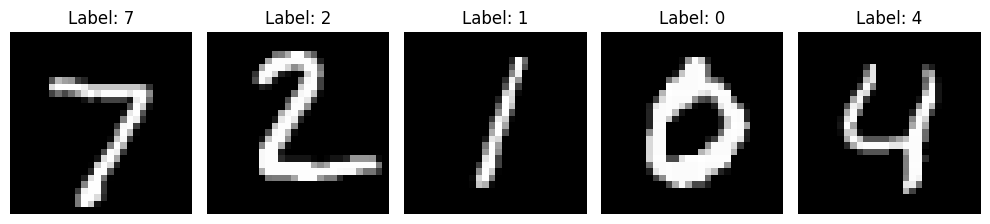

Training data shape: (60000, 28, 28, 1) (60000,)
Test data shape: (10000, 28, 28, 1) (10000,)


In [2]:
# -------------------------
# 1) Data: load + preprocess
# -------------------------
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# MNIST is 28x28 grayscale.
x_train = x_train.astype("float32")
x_test  = x_test.astype("float32")
x_train = x_train.reshape(-1, 28, 28, 1)
x_test  = x_test.reshape(-1, 28, 28, 1)

x_test_fp = x_test

#To visualize three test images from the testing set along with their corresponding labels, you can use the following code:
# Define the number of images to display
num_images = 5

# Create subplots for each image
plt.figure(figsize=(10, 3))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(x_test[i], cmap='gray')
    plt.title(f"Label: {y_test[i]}")
    plt.axis('off')  # Hide the axis

# Automatically adjusts spacing between subplots so titles and images don’t overlap.
plt.tight_layout()
plt.show()

# Check the shape of the data
print("Training data shape:", x_train.shape, y_train.shape)
print("Test data shape:", x_test.shape, y_test.shape)


## Step 3: Load Pre-trained FP32 Model

Here, we load a **pre-trained LeNet-Inspired CNN model** trained earlier in full precision (FP32).  
Make sure the file path points to your saved model file, `lenet_inspired_fp32_full.keras`).


In [3]:
# Load your trained FP32 model
fp32_model = load_model("lenet_inspired_fp32_full.keras", compile=False)
fp32_model.summary()

Model: "LeNet5_Inspired_Dynamic_FloatSim"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 16)     │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 26, 26, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 4)      │           292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 24, 24, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,134 (1.18 MB)

 Trainable params: 308,134 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

## Step 4: Evaluate FP32 Model Accuracy

Before quantization, evaluate the full-precision model on the MNIST test dataset.  
This will serve as the **baseline accuracy** for comparison after quantization.


In [4]:
# Forward pass on full test set
logits = fp32_model.predict(x_test_fp, batch_size=64)  # verbose=2 shows progress bar
preds = np.argmax(logits, axis=1)

# Compute accuracy
accuracy = np.mean(preds == y_test)
print(f"Accuracy of FP32 pre-traind model on full MNIST test set: {accuracy:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step
Accuracy of FP32 pre-traind model on full MNIST test set: 0.9870


## Step 5: Define Dynamic Rescaling Function

We define a function that normalizes, scales, and quantizes tensors to simulate 8-bit integer quantization.  
This function rescales data dynamically based on its maximum absolute value.


In [5]:
def dynamic_rescale_float_tensor(x):
    # Find per-tensor absolute max
    max_abs = tf.reduce_max(tf.abs(x))
    # Scale into [-1, 1], then multiply to match int8 range -> The int8 range is roughly [-128, 127]
    x_norm = x / max_abs
    x_scaled = tf.round(x_norm * 127.0)
    x_clipped = tf.clip_by_value(x_scaled, -127.0, 127.0) # -> Ensures values stay strictly within [-127, 127]

    # The values now represent int8 numbers, but stored as float32, simulating quantized behavior.
    return tf.cast(x_clipped, tf.float32)

## Step 6: Build Quantization Simulation Model

We create a new model with the same structure as the FP32 model.  
Then, it will receive quantized weights and quantized input data in the next steps to simulate integer-only inference.


In [6]:
# ------------------------------
# Build Functional Model
# ------------------------------
def build_lenet_dynamic_float_sim():
    inp = layers.Input(shape=(28, 28, 1))

    # Conv 1
    x = layers.Conv2D(64, (1,1), activation=None, padding="valid")(inp)
    x = layers.ReLU()(x)
    x = layers.Lambda(dynamic_rescale_float_tensor)(x)  # Simulate int8 scaling

    # Conv 2
    x = layers.Conv2D(32, (1,1), activation=None, padding="valid")(x)
    x = layers.ReLU()(x)
    x = layers.Lambda(dynamic_rescale_float_tensor)(x)

    # Conv 3
    x = layers.Conv2D(16, (1,1), activation=None, padding="valid")(x)
    x = layers.ReLU()(x)
    x = layers.Lambda(dynamic_rescale_float_tensor)(x)

    # Conv 4 (3×3)
    x = layers.Conv2D(8, (3,3), activation=None, padding="valid")(x)
    x = layers.ReLU()(x)
    x = layers.Lambda(dynamic_rescale_float_tensor)(x)

    # Conv 5 (3×3)
    x = layers.Conv2D(4, (3,3), activation=None, padding="valid")(x)
    x = layers.ReLU()(x)
    x = layers.Lambda(dynamic_rescale_float_tensor)(x)

    # Flatten
    x = layers.Flatten()(x)

    # Dense 1
    x = layers.Dense(128, activation=None)(x)
    x = layers.ReLU()(x)
    x = layers.Lambda(dynamic_rescale_float_tensor)(x)

    # Dense 2
    x = layers.Dense(64, activation=None)(x)
    x = layers.ReLU()(x)
    x = layers.Lambda(dynamic_rescale_float_tensor)(x)

    # Final Dense (no activation, raw logits)
    x = layers.Dense(10, activation=None)(x)
    x = layers.Lambda(dynamic_rescale_float_tensor)(x)  # ✅ Final scale simulation

    model = Model(inputs=inp, outputs=x, name="LeNet_Dynamic_quantization")

    return model

# ------------------------------
# Build and inspect
# ------------------------------
quantized_model = build_lenet_dynamic_float_sim()
quantized_model.summary()


Model: "LeNet_Dynamic_quantization"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 16)     │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 26, 26, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 26, 26, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 4)      │           292 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 24, 24, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 24, 24, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_6 (Lambda)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_7 (Lambda)               │ (None, 10)             │             

 Total params: 308,134 (1.18 MB)

 Trainable params: 308,134 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

## Step 7: Quantizing Pre-trained FP32 Weights

In this step, we take the weights and biases from each convolutional and dense layer in the FP32 model,  
apply our dynamic rescaling function to them, and then assign the quantized versions to the new simulation model.  
This simulates quantized **integer weights** stored as float32.


In [7]:
#------------------------------
# Extract Conv2D and Dense layers for quantization
#------------------------------
# Collect Conv/Dense layers in float_sim_model
quantized_layers = [l for l in quantized_model.layers if isinstance(l, layers.Conv2D) or isinstance(l, layers.Dense)]
fp32_layers = [l for l in fp32_model.layers if isinstance(l, layers.Conv2D) or isinstance(l, layers.Dense)]

# Transfer quantized weights
for q_l, fp32_l in zip(quantized_layers, fp32_layers):
    w, b = fp32_l.get_weights()
    w_q = dynamic_rescale_float_tensor(w)
    b_q = dynamic_rescale_float_tensor(b)
    q_l.set_weights([w_q, b_q])


## Step 8: Quantizing the MNIST Dataset

Here, we quantize the **input activations** (test images) using the same scaling principle.  
This simulates integer-only input data, which allows the entire inference pipeline to behave as if it were using int8 arithmetic.


In [8]:
# 1. Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# 2️. Convert to float32 for safe division
x_test = tf.cast(x_test, tf.float32)

# 3️. Normalize pixel values from [0, 255] → [0, 1]
x_test = x_test / 255.0

# 4️. Scale normalized values from [0, 1] → [0, 127]
x_test = x_test * 127.0

# 5️. Round to nearest integer
x_test = tf.round(x_test)

# 6️. Clip to make sure everything is within [0, 127]
x_test = tf.clip_by_value(x_test, 0.0, 127.0)

# 7. Reshape to (num_samples, 28, 28, 1)
x_test = tf.reshape(x_test, (-1, 28, 28, 1))


## Step 7: Evaluate Quantized Simulation Model

Now we evaluate the quantized simulation model to observe the effect of integer quantization on accuracy.  
Compare this accuracy to the FP32 baseline to understand quantization loss.


In [9]:
# Forward pass on full test set
logits = quantized_model.predict(x_test, batch_size=64)  # verbose=2 shows progress bar
preds = np.argmax(logits, axis=1)

# Compute accuracy
accuracy = np.mean(preds == y_test)
print(f"Accuracy of quantized model on full MNIST test set: {accuracy:.4f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step
Accuracy of quantized model on full MNIST test set: 0.9868


## Step 8: Exercise – Quantization with Smaller Integer Bit-Widths

Now that you have successfully performed **full-integer post-training quantization (PTQ)** with 8-bit integers, your task is to **repeat the same quantization process** using smaller integer representations — **from 7-bit down to 4-bit**.
Record the accuracy for each bit-width (7, 6, 5, and 4) and compare them to the 8-bit result.


### Step 8.1: Define Dynamic Rescaling Function

In [10]:
# Define Dynamic Rescaling Function
def dynamic_rescale_float_tensor(x, bit_width):
    # Find per-tensor absolute max (avoid division by zero)
    max_abs = tf.reduce_max(tf.abs(x))

    # Normalize to [-1, 1]
    x_norm = x / max_abs

    # Compute quantization limits
    qmax = float(2 ** (bit_width - 1) - 1)
    qmin = -qmax

    # Scale, round, and clip to int range
    x_scaled = tf.round(x_norm * qmax)
    x_clipped = tf.clip_by_value(x_scaled, qmin, qmax)

    # Return float32 tensor representing quantized values
    return tf.cast(x_clipped, tf.float32)

### Step 8.2: Build Quantization Simulation Model

In [11]:
def build_lenet_dynamic_float_sim(bit_width):
  inp = layers.Input(shape=(28, 28, 1))

  # Conv 1
  x = layers.Conv2D(64, (1,1), activation=None, padding="valid")(inp)
  x = layers.ReLU()(x)
  x = layers.Lambda(dynamic_rescale_float_tensor, arguments={'bit_width': bit_width})(x)  # Simulate int8 scaling

  # Conv 2
  x = layers.Conv2D(32, (1,1), activation=None, padding="valid")(x)
  x = layers.ReLU()(x)
  x = layers.Lambda(dynamic_rescale_float_tensor, arguments={'bit_width': bit_width})(x)

  # Conv 3
  x = layers.Conv2D(16, (1,1), activation=None, padding="valid")(x)
  x = layers.ReLU()(x)
  x = layers.Lambda(dynamic_rescale_float_tensor, arguments={'bit_width': bit_width})(x)

  # Conv 4 (3×3)
  x = layers.Conv2D(8, (3,3), activation=None, padding="valid")(x)
  x = layers.ReLU()(x)
  x = layers.Lambda(dynamic_rescale_float_tensor, arguments={'bit_width': bit_width})(x)

  # Conv 5 (3×3)
  x = layers.Conv2D(4, (3,3), activation=None, padding="valid")(x)
  x = layers.ReLU()(x)
  x = layers.Lambda(dynamic_rescale_float_tensor, arguments={'bit_width': bit_width})(x)

  # Flatten
  x = layers.Flatten()(x)

  # Dense 1
  x = layers.Dense(128, activation=None)(x)
  x = layers.ReLU()(x)
  x = layers.Lambda(dynamic_rescale_float_tensor, arguments={'bit_width': bit_width})(x)

  # Dense 2
  x = layers.Dense(64, activation=None)(x)
  x = layers.ReLU()(x)
  x = layers.Lambda(dynamic_rescale_float_tensor, arguments={'bit_width': bit_width})(x)

  # Final Dense (no activation, raw logits)
  x = layers.Dense(10, activation=None)(x)
  x = layers.Lambda(dynamic_rescale_float_tensor, arguments={'bit_width': bit_width})(x)  # ✅ Final scale simulation

  model = Model(inputs=inp, outputs=x, name="LeNet_Dynamic_quantization")

  return model


### Step 8.3
1. Quantizing Pre-trained FP32 Weights
2. Quantizing the MNIST Dataset
3. Evaluate Quantized Simulation Model

In [12]:
# For bit-width 7, 6, 5, 4
bit_widths = [7, 6, 5, 4]

for bit_width in bit_widths:
  quantized_model = build_lenet_dynamic_float_sim(bit_width)

  # Quantizing Pre-trained FP32 Weights
  quantized_layers = [l for l in quantized_model.layers if isinstance(l, layers.Conv2D) or isinstance(l, layers.Dense)]
  fp32_layers = [l for l in fp32_model.layers if isinstance(l, layers.Conv2D) or isinstance(l, layers.Dense)]

  # Transfer quantized weights
  for q_l, fp32_l in zip(quantized_layers, fp32_layers):
      w, b = fp32_l.get_weights()
      w_q = dynamic_rescale_float_tensor(w, bit_width)
      b_q = dynamic_rescale_float_tensor(b, bit_width)
      q_l.set_weights([w_q, b_q])

  # Quantizing the MNIST Dataset
  qmax = float(2 ** (bit_width - 1) - 1)
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
  x_test = tf.cast(x_test, tf.float32)
  x_test = x_test / 255.0
  x_test = x_test * qmax
  x_test = tf.round(x_test)

  x_test = tf.clip_by_value(x_test, 0.0, qmax)

  x_test = tf.reshape(x_test, (-1, 28, 28, 1))

  # Evaluate Quantized Simulation Model
  logits = quantized_model.predict(x_test, batch_size=64)
  preds = np.argmax(logits, axis=1)

  accuracy = np.mean(preds == y_test)
  print(f"Accuracy of quantized model (bit_width = {bit_width}) on full MNIST test set: {accuracy:.4f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step
Accuracy of quantized model (bit_width = 7) on full MNIST test set: 0.9859
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step
Accuracy of quantized model (bit_width = 6) on full MNIST test set: 0.9865
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step
Accuracy of quantized model (bit_width = 5) on full MNIST test set: 0.9821
157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step
Accuracy of quantized model (bit_width = 4) on full MNIST test set: 0.7847
